In [37]:
using LinearAlgebra
using SparseArrays
using OrdinaryDiffEq
using DiffEqFlux
using Plots

Helper function for visualizing matrices

In [38]:
plotmat(A; kwargs...) = heatmap(
    reverse(A; dims = 1);
    aspect_ratio = :equal,
    xlims = (1 / 2, size(A, 1) + 1 / 2),
    ylims = (1 / 2, size(A, 2) + 1 / 2),
    kwargs...,
)

plotmat (generic function with 2 methods)

Convert sparse matrices to dense for plotting

In [39]:
plotmat(A::AbstractSparseMatrix; kwargs...) = plotmat(Matrix(A); kwargs...)

plotmat (generic function with 2 methods)

# Problem statement
Consider the diffusion equation

    ∂u/∂t = κ ∂²u/∂x²,    x ∈ Ω = [a, b]

with diffusivity κ > 0 and homogeneous Dirichlet boundary conditions u(a, t) = u(b, t) = 0.
The initial conditions are given by u(x, 0) = u₀(x).

Problem parameters

In [40]:
κ = 0.01
a = 0.0
b = 1.0
L = b - a

1

Spatial discretization

In [41]:
N = 50
x = LinRange(a, b, N + 1)
Δx = L / N

0.02

Discrete approximation of diffusion operator ∂²/∂x² with constant Dirichlet boundary
conditions. This approximation is second order accurate: |(Du)ᵢ - ∂²u/∂x²(xᵢ)| = 𝒪(Δx²).

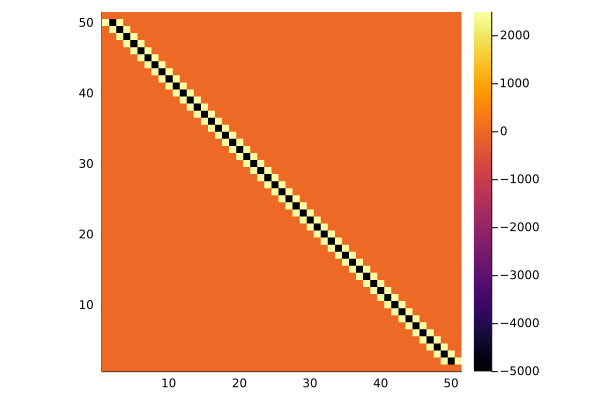

In [42]:
D = 1 / Δx^2 * spdiagm(N + 1, N + 1, -1 => fill(1.0, N), 0 => fill(-2.0, N + 1), 1 => fill(1.0, N))
D[1, :] .= 0 # Do not change first value
D[end, :] .= 0 # Do not change last value
plotmat(D)

ODE solver for given operator and initial conditions

In [43]:
f(u, A, t) = A * u
function S(A, u₀, t)
    problem = ODEProblem(ODEFunction(f), u₀, (0.0, t), A)
    sol = solve(problem, Tsit5(); save_everystep = false)
    sol.u[end]
end

S (generic function with 1 method)

Exact operator for given discretization

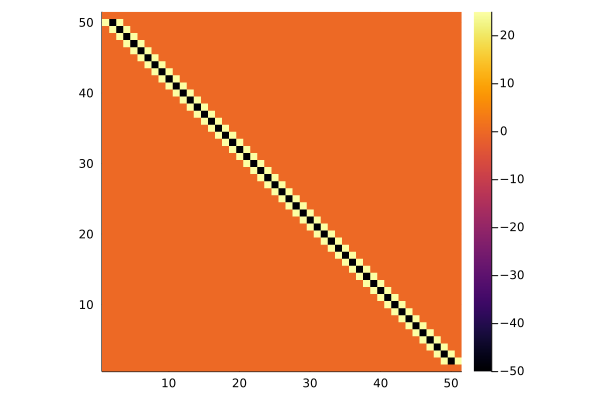

In [44]:
A_exact = κ * D
plotmat(A_exact)

Basis functions for exact solutions with homogeneous Dirichlet boundary conditions

In [45]:
X(n, x) = sin(π * n * x / L)
T(n, t) = exp(-κ * (π * n / L)^2 * t)
create_data(c, n) = (x, t) -> sum(c * T(n, t) * X(n, x) for (c, n) in zip(c, n))

create_data (generic function with 1 method)

A particular solution

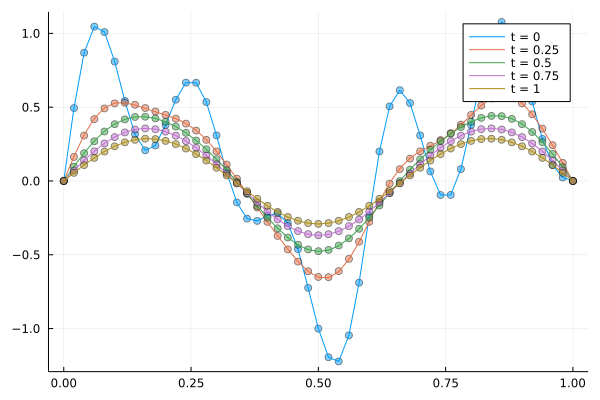

In [46]:
n = [3, 7, 10]
c = [0.7, 0.3, 0.4]
u = create_data(c, n)
p = plot();
for (i, t) ∈ enumerate(LinRange(0.0, 1.0, 5))
    scatter!(p, x, u.(x, t); label = nothing, markeralpha = 0.5, color = i) # Exact
    plot!(p, x, S(A_exact, u.(x, 0.0), t); label = "t = $t", color = i) # FOM
end
p

# Proper orthogonal decomposition (POD)

Snapshots

In [47]:
t = LinRange(0, 1.0, 101)

101-element LinRange{Float64, Int64}:
 0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,…,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1

Exact snapshot matrix

In [48]:
U = mapreduce(t -> u.(x, t), hcat, t)

51×101 Matrix{Float64}:
 0          0          0        0          …  0          0          0
 0.494      0.4647     0.4378   0.4131        0.05606    0.05552    0.05498
 0.8693     0.8203     0.7753   0.7338        0.1099     0.1089     0.1079
 1.046      0.9933     0.9445   0.8995        0.1596     0.1581     0.1566
 1.009      0.9687     0.9313   0.8963        0.2032     0.2013     0.1995
 0.809      0.7926     0.7767   0.7613     …  0.2393     0.2371     0.2349
 0.5428     0.5525     0.5604   0.5669        0.2665     0.2641     0.2617
 0.3164     0.3453     0.3709   0.3935        0.2841     0.2815     0.279
 0.2078     0.2425     0.2738   0.3018        0.2916     0.289      0.2865
 0.2407     0.267      0.2907   0.3122        0.2889     0.2864     0.2839
 0.3804     0.388      0.395    0.4014     …  0.2763     0.2739     0.2716
 0.5509     0.5374     0.5254   0.5147        0.2543     0.2521     0.25
 0.6665     0.6379     0.6122   0.589         0.2237     0.2218     0.2199
 ⋮      

Approximate snapshot matrix using finite differences in space (`D`) and ODE solver
(`Tsit5`)

In [49]:
U = mapreduce(t -> S(A_exact, u.(x, 0.0), t), hcat, t)

51×101 Matrix{Float64}:
 0          0          0          …  0          0          0
 0.494      0.4655     0.4392        0.05629    0.05575    0.05521
 0.8693     0.8216     0.7776        0.1104     0.1093     0.1083
 1.046      0.9946     0.947         0.1602     0.1587     0.1572
 1.009      0.9697     0.9329        0.204      0.2021     0.2002
 0.809      0.7927     0.777      …  0.24       0.2378     0.2356
 0.5428     0.5519     0.5594        0.2673     0.2648     0.2625
 0.3164     0.3442     0.3689        0.2848     0.2823     0.2798
 0.2078     0.2414     0.2717        0.2922     0.2897     0.2872
 0.2407     0.2661     0.2892        0.2895     0.287      0.2845
 0.3804     0.3878     0.3946     …  0.2768     0.2745     0.2722
 0.5509     0.5379     0.5263        0.2547     0.2526     0.2505
 0.6665     0.6389     0.6139        0.2241     0.2222     0.2203
 ⋮                                ⋱                        ⋮
 0.08067    0.1105     0.1378        0.2547     0.2526     0.

Augmented snapshot matrix (many different initial conditions)

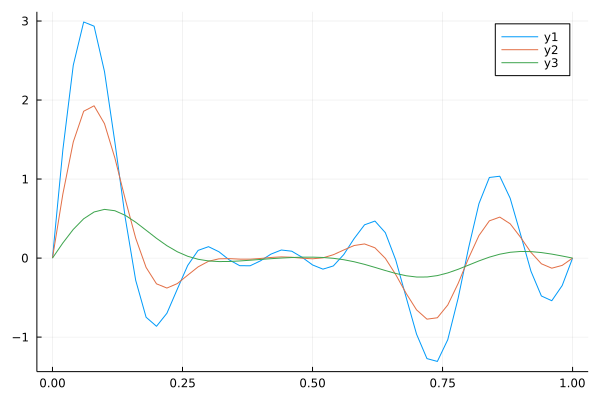

51×3030 Matrix{Float64}:
  0           0           0          …  0          0          0
  1.372       1.297       1.227         0.1363     0.1351     0.1338
  2.441       2.312       2.191         0.2676     0.2652     0.2629
  2.988       2.839       2.7           0.3893     0.386      0.3827
  2.935       2.806       2.684         0.4976     0.4935     0.4895
  2.36        2.281       2.205      …  0.5895     0.5849     0.5804
  1.465       1.449       1.432         0.663      0.6583     0.6536
  0.5067      0.5486      0.5853        0.7175     0.7128     0.7082
 -0.281      -0.2022     -0.1304        0.7533     0.7489     0.7445
 -0.7485     -0.6614     -0.5807        0.7713     0.7674     0.7634
 -0.8631     -0.7939     -0.7288     …  0.7735     0.77       0.7666
 -0.6984     -0.6633     -0.6287        0.7618     0.759      0.7561
 -0.393      -0.394      -0.3924        0.7387     0.7364     0.7341
  ⋮                                  ⋱                        
 -0.5065     -0.4799

In [73]:
uu = [create_data(rand(10), 1:10) for _ = 1:30]
p = plot()
plot!(p, x, uu[1].(x, 0))
plot!(p, x, uu[1].(x, 0.1))
plot!(p, x, uu[1].(x, 0.5))
display(p)
U = mapreduce(u -> u.(x, t'), hcat, uu)

Build POD basis, keeping only the N_POD first modes

In [51]:
N_POD = 10
F = svd(U)
Φ = F.U[:, 1:N_POD]

51×10 Matrix{Float64}:
 -3.331e-16  -1.943e-16   4.441e-16  …   6.661e-16  -5.551e-17  -2.776e-16
 -0.1188     -0.1155      0.1363         0.04841    -0.00724    -0.00162
 -0.2211     -0.2061      0.2376         0.07036    -0.01155    -0.0009967
 -0.294      -0.2536      0.2786         0.05079    -0.0119      0.001991
 -0.3318     -0.2512      0.2505        -0.007059   -0.009992    0.004529
 -0.3361     -0.2045      0.1624     …  -0.08198    -0.009626    0.002008
 -0.3151     -0.1293      0.03845       -0.1424     -0.01466    -0.009271
 -0.2808     -0.04621    -0.09027       -0.1586     -0.02645    -0.02914
 -0.245       0.02529    -0.1946        -0.1145     -0.04205    -0.05195
 -0.2167      0.07237    -0.2553        -0.01557    -0.05409    -0.06756
 -0.2         0.09153    -0.2673     …   0.1119     -0.05284    -0.06489
 -0.1938      0.08822    -0.2391         0.2286     -0.02997    -0.03697
 -0.1936      0.07364    -0.1889         0.2949      0.01738     0.01457
  ⋮                 

Plot some POD modes

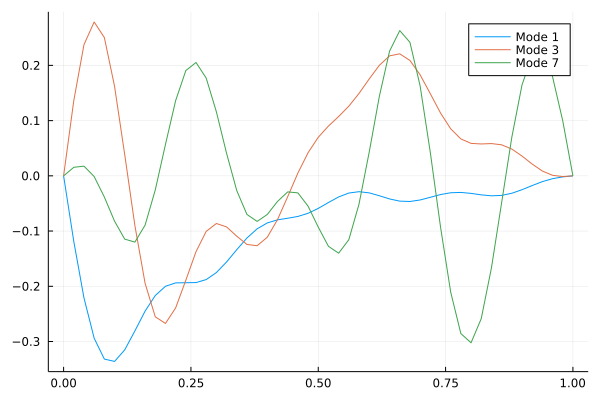

In [52]:
p = plot();
for i ∈ [1, 3, 7]
    plot!(x, Φ[:, i]; label = "Mode $i")
    # plot!(x, X.(i, x); label = "i = $i")
end
p

Check orthogonality

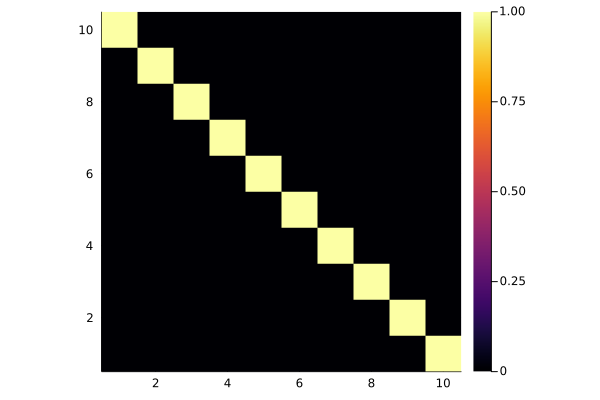

In [53]:
plotmat(Φ'Φ)

Φ * Φ' can be considered an autoencoder, with "encoder" Φ' and "decoder" Φ.
The "autoencoder" should be closer to identity when keeping more modes

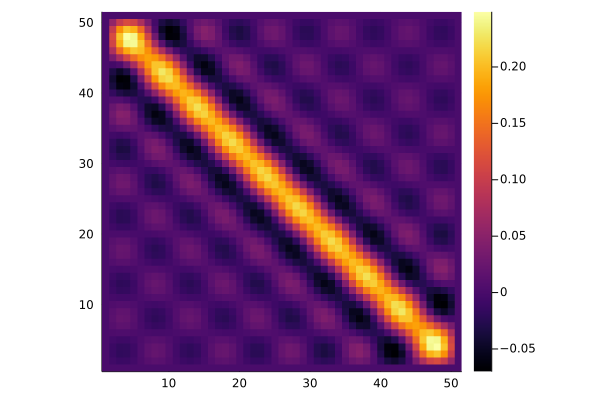

In [54]:
plotmat(Φ * Φ')

POD reduced order model (S_POD): Approximates the full order model (S)

In [55]:
A_POD = κ * Φ' * D * Φ
function S_POD(A_POD, u₀, t)
    a₀ = Φ'u₀
    a = S(A_POD, a₀, t) # ROM and FOM have the same form, but different size
    Φ * a
end

S_POD (generic function with 1 method)

Compare with full order model

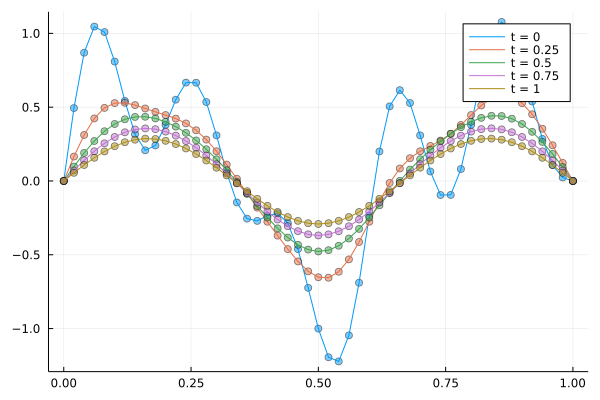

In [56]:
p = plot();
for (i, t) ∈ enumerate(LinRange(0.0, 1.00, 5))
    # scatter!(p, x, u.(x, t); label = nothing, markeralpha = 0.5, color = i) # Exact
    scatter!(p, x, S(A_exact, u.(x, 0.0), t); label = nothing, markeralpha = 0.5, color = i) # FOM
    plot!(p, x, S_POD(A_POD, u.(x, 0.0), t); label = "t = $t", color = i) # ROM
end
p

# Learning A intrusively

Build some training data: Snapshots of different initial conditions diffused to different
times

In [57]:
ttrain = LinRange(0.0, 1.0, 5)[2:end]
ntrain = 100
nfreq = 10
c = [rand(nfreq) for _ = 1:ntrain]
n = 1:nfreq
uu = [create_data(c, n) for c ∈ c]
uu0 = [u.(x, 0.0) for u ∈ uu]
train = [u.(x, t) for t ∈ ttrain, u ∈ uu]

4×100 Matrix{Vector{Float64}}:
 [0, 0.6093, 1.132, 1.498, 1.672, 1.654, 1.481, 1.212, 0.9161, 0.6545  …  0.4275, 0.322, 0.2309, 0.1594, 0.1077, 0.0722, 0.04792, 0.02988, 0.01454, 2.815e-17]       …  [0, 0.4803, 0.9016, 1.218, 1.408, 1.473, 1.44, 1.345, 1.229, 1.122  …  0.723, 0.62, 0.4871, 0.3374, 0.1906, 0.06805, -0.01296, -0.04539, -0.03514, -7.708e-17]
 [0, 0.2925, 0.558, 0.7741, 0.9259, 1.008, 1.025, 0.9889, 0.9169, 0.8274  …  0.4112, 0.3511, 0.2899, 0.2314, 0.1783, 0.1317, 0.09183, 0.0577, 0.02776, 5.338e-17]       [0, 0.2693, 0.5204, 0.7379, 0.9108, 1.034, 1.11, 1.142, 1.14, 1.114  …  0.5944, 0.523, 0.4434, 0.3606, 0.2798, 0.2057, 0.1411, 0.08678, 0.04097, 7.821e-17]
 [0, 0.1819, 0.3526, 0.5024, 0.624, 0.7132, 0.7692, 0.7944, 0.7937, 0.7733  …  0.3749, 0.3348, 0.2912, 0.2461, 0.2011, 0.1574, 0.1155, 0.07566, 0.03739, 7.257e-17]     [0, 0.191, 0.3735, 0.5398, 0.6839, 0.8018, 0.8914, 0.9532, 0.9892, 1.003  …  0.5324, 0.4805, 0.4227, 0.3613, 0.2983, 0.2356, 0.1742, 0.1147, 0.05683, 

Performance metric: Compare prediction with snapshot of exact solution

In [58]:
loss(A, u₀, uₜ, t) = sum(abs2, S(A, u₀, t) - uₜ)

loss (generic function with 2 methods)

Average performance over all snapshots and initial condtions

In [59]:
function loss(A)
    e = 0.0
    for i = 1:ntrain
        u₀ = uu0[i]
        for j = 1:length(ttrain)
            t = ttrain[j]
            uₜ = train[j, i]
            e += loss(A, u₀, uₜ, t)
        end
    end
    e / ntrain / length(ttrain)
end

loss (generic function with 2 methods)

Function for visualizing prediction performance

In [60]:
function ploterr(A, u)
    p = plot()
    for (i, t) ∈ enumerate(LinRange(0.0, 1.0, 5))
        scatter!(p, x, u.(x, t); label = nothing, markeralpha = 0.5, color = i)
        plot!(p, x, S(A, u.(x, 0.0), t); label = "t = $t", color = i)
    end
    p
end

ploterr (generic function with 1 method)

Callback (called after every iteration of gradient descent)

In [61]:
function cb(A, loss)
    println(loss)
    display(plot(plotmat(A), plotmat(A_exact); layout = (1, 2)))
    false
end

cb (generic function with 1 method)

In [62]:
function cb(A, loss)
    println(loss)
    display(ploterr(A, uu[10]))
    flush(stdout)
    false
end

cb (generic function with 1 method)

In [68]:
cb(A, loss) = (println(loss); flush(stdout); false)

cb (generic function with 1 method)

Initial guess for the "unknown" operator A_exact

In [69]:
A = zeros(N + 1, N + 1)
cb(A, loss(A))

45.7


false

Improve operator though gradient descent applied to loss function

In [70]:
result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb, maxiters = 500)
A = result.u

45.7
37.24
31.28
26.38
22.38
19.09
16.42
14.22
12.39
10.87
9.605
8.537
7.649
6.926
6.345
5.874
5.489
5.172
4.916
4.706
4.53
4.379
4.248
4.13
4.024
3.925
3.827
3.729
3.636
3.549
3.465
3.384
3.308
3.236
3.166
3.097
3.027
2.958
2.888
2.819
2.75
2.683
2.617
2.551
2.488
2.426
2.367
2.311
2.258
2.207
2.157
2.111
2.066
2.024
1.984
1.945
1.907
1.871
1.837
1.804
1.772
1.742
1.713
1.685
1.659
1.633
1.608
1.583
1.56
1.537
1.515
1.493
1.472
1.452
1.432
1.412
1.393
1.375
1.356
1.339
1.321
1.304
1.287
1.27
1.254
1.238
1.222
1.207
1.192
1.177
1.162
1.148
1.134
1.12
1.106
1.093
1.08
1.067
1.055
1.042
1.03
1.018
1.006
0.9946
0.9832
0.972
0.9609
0.9501
0.9395
0.929
0.9187
0.9085
0.8985
0.8887
0.879
0.8695
0.8602
0.8509
0.8419
0.833
0.8243
0.8161
0.8091
0.8065
0.8171
0.8525
0.8745
0.809
0.7606
0.8032
0.7802
0.7376
0.7677
0.7393
0.7214
0.7377
0.704
0.7102
0.7022
0.6836
0.692
0.6705
0.672
0.6636
0.6524
0.6539
0.6387
0.6393
0.6296
0.6233
0.6205
0.6099
0.6088
0.5998
0.5954
0.5908
0.583
0.5805
0.573
0.5688
0.

51×51 Matrix{Float64}:
 0   0           0         0         …   0         0         0
 0  -0.2575     -0.2469   -0.2407        0.4508    0.6103    0.453
 0  -0.42       -0.425    -0.4226        0.8561    1.066     0.7516
 0  -0.4944     -0.4976   -0.4995        0.9971    1.281     1.097
 0  -0.4573     -0.4625   -0.4683        0.8468    1.179     1.017
 0  -0.3279     -0.3362   -0.3447    …   0.4262    0.7908    0.6123
 0  -0.1409     -0.1382   -0.1543       -0.06042   0.2183    0.4476
 0   0.2451      0.1792    0.1175       -0.1372    0.1168    0.6585
 0   0.3793      0.3342    0.288        -0.3755   -0.1957   -0.07235
 0   0.3469      0.3248    0.3016       -0.4932   -0.6244   -1.008
 0   0.2913      0.275     0.2649    …  -0.3313   -0.5962   -1.366
 0   0.2378      0.2157    0.2123        0.06064  -0.06406  -0.7553
 0   0.0834      0.06673   0.08796       0.412     0.3468   -0.2192
 ⋮                                   ⋱                       ⋮
 0  -0.06049    -0.01612   0.005497    

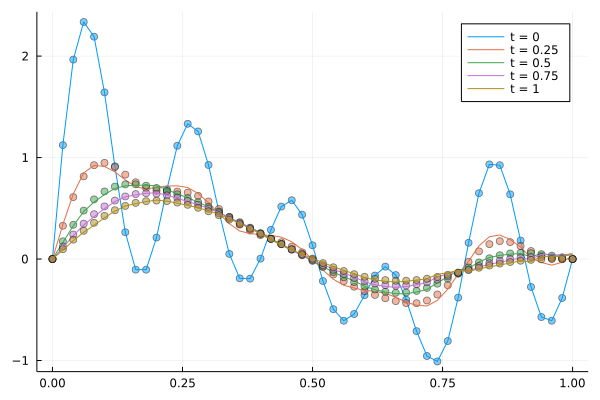

In [71]:
ploterr(A, uu[10])

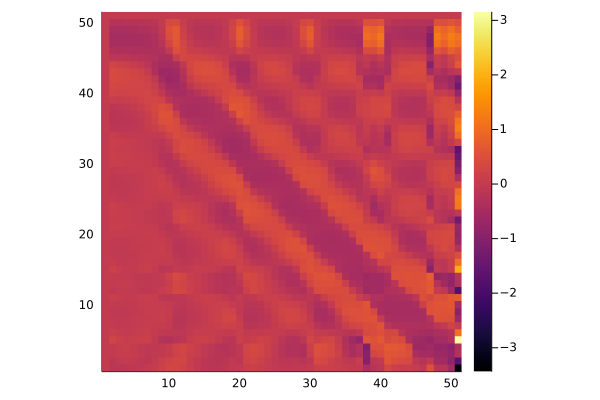

In [72]:
plotmat(A)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*